# MIE1624 Group 11 _ Course Project

In [1]:
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time
import requests
import numpy as np

import nltk
from nltk.stem import *
from nltk.corpus import stopwords
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.tag import PerceptronTagger
from nltk.data import find

from collections import Counter
import string
import re
import smtplib

from urllib.parse import urljoin
import lxml.html

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
import sklearn.metrics as metrics

C:\Users\zhang\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Data Acqusition & Cleaning

### 1.0 Generate links & Skill Evaluation 

In [2]:
# define a new dataframe to store the evaluation results 
skills = ['job_title','company_name','location', 'job_link','python', 'r', "sql", 'sas', 'java', 'matlab', 'c++', 'scala','excel','hadoop','spark','tableau', 'total_skills_count'] #'job link',
skill_required = pd.DataFrame(columns = skills)

link_input = list()
python_input = list()
r_input = list()
sql_input = list()
sas_input = list()
java_input = list()
MATLAB_input = list()
Cplus_input = list()
scala_input = list()
excel_input = list()
hadoop_input = list()
spark_input = list()
tableau_input = list()
total_input = list()

In [3]:

# function to evaluate single job site. 
#Skill ranking reference: http://www.jungle-ml.com/2017/09/17/data-science-job-qualifications-via-web-scraping-indeed-com/


def evaluate_job(job_url):
    
    try:
        job_html = requests.request('GET', job_url, timeout = 25)
    except:
        return 0
    
    job_soup = bs4.BeautifulSoup(job_html.content, 'lxml')
    soup_body = job_soup('body')[0]
    
    link_input.append(job_url)
    
    python_count = soup_body.text.count('Python') + soup_body.text.count('python')
    python_input.append(python_count)
    
    r_count = len(re.findall('R[\,\.]', soup_body.text)) # this one's not perfect, but I blame R's name
    r_input.append(r_count)
    
    sql_count = soup_body.text.count('SQL') + soup_body.text.count('sql')
    sql_input.append(sql_count)

    
    sas_count = soup_body.text.count('SAS') + soup_body.text.count('sas')
    sas_input.append(sas_count)
    
    
    Java_count = soup_body.text.count('Java') + soup_body.text.count('java') + soup_body.text.count('JAVA')
    java_input.append(Java_count)
    
    
    MATLAB_count = soup_body.text.count('MATLAB') + soup_body.text.count('Matlab') + soup_body.text.count('matlab')
    MATLAB_input.append(MATLAB_count)
    
    Cplus_count = soup_body.text.count('C++') + soup_body.text.count('c++')
    Cplus_input.append(Cplus_count)
    
    scala_count = soup_body.text.count('scala') + soup_body.text.count('Scala')
    scala_input.append(scala_count)
    
    excel_count = soup_body.text.count('Excel') + soup_body.text.count('excel')
    excel_input.append(excel_count)
    
    hadoop_count = soup_body.text.count('Hadoop') + soup_body.text.count('hadoop')
    hadoop_input.append(hadoop_count)
    
    tableau_count = soup_body.text.count('Tableau') + soup_body.text.count('tableau')
    tableau_input.append(tableau_count)
    
    spark_count = soup_body.text.count('Spark') + soup_body.text.count('spark')
    spark_input.append(spark_count)
    
    skill_count = int(python_count) + int(sql_count) + int(r_count) + int(sas_count) + int(Java_count) +  int(MATLAB_count) +  int(Cplus_count) + int(scala_count) + int(excel_count)+ int(hadoop_count)+ int(spark_count)+int(tableau_count)
    total_input.append(skill_count)
        
    return link_input, python_input, r_input, sql_input, sas_input, java_input, MATLAB_input, Cplus_input, scala_input,excel_input, hadoop_input,spark_input, tableau_input, total_input

In [4]:
# define interested city list

#city_set = ['Toronto', 'Montreal','Calgary']
city_set = ['Toronto','Vancouver','Montreal','Mississauga','Calgary','Edmonton','Ottawa','Winnipeg','Burnaby','Concord','Waterloo','Victoria','Markham','Saskatoon']

In [5]:
# still need to incorporate in different cities? 

linklist = list()
max_results_per_city = 100
job_title = []
company_name = []
location = []
def getlinkindeed (joblist,df): 
#     global skill_required
    base_link = 'https://www.indeed.com/'
    start = time.time()
    for city in city_set:
        for start in range(0, max_results_per_city, 10):
            page = requests.get('https://ca.indeed.com/jobs?q='+str(joblist)+'&l=' + str(city) + '&sort=date'+'&start=' + str(start))
            soup = BeautifulSoup(page.text, 'lxml')#, from_encoding='utf-8')
            for div in soup.find_all(name="div", attrs={"class":"row"}):
            #append job link
                for a in div.find_all(name="a", attrs={'data-tn-element':'jobTitle'}):
                    finallinktext = base_link+a['href']
                    linklist.append(base_link+a['href'])
                    
                    try:
                        job_title.append(a['title'])
                    except:
                        job_title.append('NAN')
                        
                    link_num, python_num, r_num, sql_num, sas_num, java_num, MATLAB_num, Cplus_num, scala_num,excel_num, hadoop_num,spark_num,tableau_num, total_num = evaluate_job(finallinktext)
            
                company = div.find_all(name="span", attrs={"class":"company"})
                if len(company) > 0:
                    for b in company:
                        company_name.append(b.text.strip())
                        break
                    else:
                        sec_try = div.find_all(name="span", attrs={"class":"result-link-source"})
                        for span in sec_try:
                            company_name.append(span.text)
                c = div.findAll('span', attrs={'class': 'location'})
                for span in c:
                    location.append(span.text)
    
#     print(len(job_title))
#     print(len(company_name))
#     print(len(link_num))
    
    df['job_title'] = job_title
    df['company_name'] = company_name
    df['location'] = location
    df['job_link'] = link_num
    df['python'] = python_num
    df['r'] = r_num
    df['sql'] = sql_num
    df['sas'] = sas_num
    df['java'] = java_num
    df['matlab'] = MATLAB_num
    df['c++'] = Cplus_num
    df['scala'] = scala_num
    df['excel'] = excel_num
    df['hadoop'] = hadoop_num
    df['spark'] = spark_num
    df['tableau'] = tableau_num
    df['total_skills_count'] = total_num
    
    return linklist, df

In [6]:
Link_final, final_skill_required = getlinkindeed ('data+scientist',skill_required)

In [7]:
final_skill_required.head()

,job_title,company_name,location,job_link,python,r,sql,sas,java,matlab,c++,scala,excel,hadoop,spark,tableau,total_skills_count
0,Senior Environmental Scientist,Arcadis,"Mississauga, ON",https://www.indeed.com//rc/clk?jk=39ce6a7f25cf...,0,2,0,0,0,0,0,0,2,0,0,0,4
1,Financial Reporting Analyst,Xaxis,"Toronto, ON",https://www.indeed.com//rc/clk?jk=2d01f9cb9ce0...,0,0,0,0,0,0,0,0,2,0,0,0,2
2,Finance Partner,SickKids,"Toronto, ON",https://www.indeed.com//rc/clk?jk=5aacb0ed9a1f...,0,1,0,0,0,0,0,0,3,0,0,0,4
3,Full Stack Developer - Pipeline,EQ Works,"Toronto, ON",https://www.indeed.com//rc/clk?jk=ce86a5c3b335...,1,0,1,0,1,0,0,1,0,0,0,0,4
4,Software Development Manager,Autodesk,"Toronto, ON",https://www.indeed.com//rc/clk?jk=ae06baba3741...,1,1,2,0,1,0,1,0,0,0,0,0,6


#### Job Summary Cleanning

In [8]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def getjobsummary (df): 
    Summarylist = list()

    for i in range(len(df)):
        urllink = df['job_link'][i]
        
        page = requests.get(urllink)
        soup = BeautifulSoup(page.text, 'lxml')#, from_encoding='utf-8')
        summarytext=soup.find('span',{'class':'summary'})
        Summarylist.append(summarytext)
    
    k = Summarylist
    for i in range(len(k)):
        k[i] = remove_tags(str(k[i]))
        k[i] = k[i].replace('\n','')        
        k[i] = k[i].replace('\n','')
        k[i] = k[i].lower()
        k[i] = k[i].replace('·','')
        
        
    
    df['summary'] = k
    df2 = df[['job_title','company_name','location', 'summary', 'python','r','sql','sas','java','matlab','c++','scala','excel','hadoop','spark','tableau','total_skills_count', 'job_link']]
    
    return df2  

In [9]:
final_skill_required2 = getjobsummary (final_skill_required)
final_skill_required2.head()

,job_title,company_name,location,summary,python,r,sql,sas,java,matlab,c++,scala,excel,hadoop,spark,tableau,total_skills_count,job_link
0,Senior Environmental Scientist,Arcadis,"Mississauga, ON",arcadis canada is currently seeking senior hyd...,0,2,0,0,0,0,0,0,2,0,0,0,4,https://www.indeed.com//rc/clk?jk=39ce6a7f25cf...
1,Financial Reporting Analyst,Xaxis,"Toronto, ON","at xaxis, you will collaborate with a group of...",0,0,0,0,0,0,0,0,2,0,0,0,2,https://www.indeed.com//rc/clk?jk=2d01f9cb9ce0...
2,Finance Partner,SickKids,"Toronto, ON",the finance partner position in research award...,0,1,0,0,0,0,0,0,3,0,0,0,4,https://www.indeed.com//rc/clk?jk=5aacb0ed9a1f...
3,Full Stack Developer - Pipeline,EQ Works,"Toronto, ON","as pipeline developer, you will own critical p...",1,0,1,0,1,0,0,1,0,0,0,0,4,https://www.indeed.com//rc/clk?jk=ce86a5c3b335...
4,Software Development Manager,Autodesk,"Toronto, ON",software development manager 18wd27796 america...,1,1,2,0,1,0,1,0,0,0,0,0,6,https://www.indeed.com//rc/clk?jk=ae06baba3741...


In [10]:
# Job Summary Example
final_skill_required2['summary'][0]

'the finance partner position in research awards and financial services will report to the grants management office manager or controller and will be part of a team responsible for approximately $120 million in annual grant revenues. the successful candidate will build working relationships with world renowned principal investigators and scientists and manage their financial grant portfolio as their main point of contact for post-award grant operations and will perform grant related post-award functions which include financial planning, budgeting, forecasting, compliance and expense analysis, and financial reporting.here’s what you’ll get to do:build working relationships with world renowned principal investigators and scientists and manage their financial grant portfolio as their main point of contact for post-award grant operations. p ortfolio will include up to 50 principal investigators and scientists with up to 300 grant projects.performs financial planning, budgeting, compliance,

#### Data Scientist Skill Evaluation Part: 

In [11]:
def skillvis (df):
    dataplot = df[['python', 'r', "sql", 'sas', 'java', 'matlab', 'c++', 'scala','excel','hadoop','spark','tableau']].sum()
    # Visualization 
    plt.figure()
    plt.figure(figsize=(10,8))
    dataplot = dataplot.sort_values(ascending=False)
    dataplot.plot(kind='bar')
    plt.ylabel('count')
    plt.xlabel('Mentioned Technical skills')
    plt.show()
    return dataplot

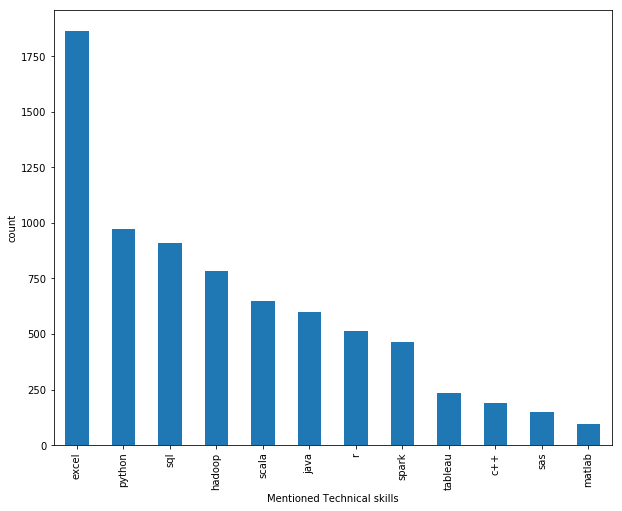

excel      1864
python      974
sql         908
hadoop      784
scala       649
java        600
r           515
spark       464
tableau     234
c++         191
sas         150
matlab       94
dtype: int64

In [12]:
skillvis (final_skill_required2)

### Data Engineer Analysis

In [13]:
# # define a new dataframe to store the evaluation results 
skills = ['job_title','company_name','location', 'job_link','python', 'r', "sql", 'sas', 'java', 'matlab', 'c++', 'scala','excel','hadoop','spark','tableau', 'total_skills_count'] #'job link',
skill_required3 = pd.DataFrame(columns = skills)

link_input = list()
python_input = list()
r_input = list()
sql_input = list()
sas_input = list()
java_input = list()
MATLAB_input = list()
Cplus_input = list()
scala_input = list()
excel_input = list()
hadoop_input = list()
spark_input = list()
tableau_input = list()
total_input = list()

linklist = list()
max_results_per_city = 11
job_title = []
company_name = []
location = []

In [14]:
Link_final_engineer, final_skill_required_engineer = getlinkindeed ('data+engineer',skill_required3)
final_skill_required_engineer=final_skill_required_engineer[final_skill_required_engineer.job_title != 'NAN']

In [15]:
final_skill_required_engineer.index = pd.RangeIndex(len(final_skill_required_engineer.index))

final_skill_required_engineer.index = range(len(final_skill_required_engineer.index))
final_skill_required_engineer.head(3)

,job_title,company_name,location,job_link,python,r,sql,sas,java,matlab,c++,scala,excel,hadoop,spark,tableau,total_skills_count
0,Intermediate Hydrogeologist/Engineer,Matrix Solutions Inc.,"Mississauga, ON",https://www.indeed.com//rc/clk?jk=0b6d70f4207e...,0,0,0,0,0,0,0,1,1,0,0,0,2
1,Full Stack Developer,Willis Towers Watson,"Toronto, ON",https://www.indeed.com//rc/clk?jk=d677ab29e743...,0,0,1,0,2,0,0,0,0,0,0,0,3
2,Project Coordinator,Miller Paving Limited,"Markham, ON",https://www.indeed.com//rc/clk?jk=6ae94895b47a...,0,0,0,0,0,0,0,0,3,0,0,0,3


In [16]:
final_skill_required_engineer2 = getjobsummary (final_skill_required_engineer)
final_skill_required_engineer2.head()

C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,job_title,company_name,location,summary,python,r,sql,sas,java,matlab,c++,scala,excel,hadoop,spark,tableau,total_skills_count,job_link
0,Intermediate Hydrogeologist/Engineer,Matrix Solutions Inc.,"Mississauga, ON","matrix solutions inc. is a canadian, employee-...",0,0,0,0,0,0,0,1,1,0,0,0,2,https://www.indeed.com//rc/clk?jk=0b6d70f4207e...
1,Full Stack Developer,Willis Towers Watson,"Toronto, ON",replace services ulc is an insuretech startup ...,0,0,1,0,2,0,0,0,0,0,0,0,3,https://www.indeed.com//rc/clk?jk=d677ab29e743...
2,Project Coordinator,Miller Paving Limited,"Markham, ON",assist with overall project performance includ...,0,0,0,0,0,0,0,0,3,0,0,0,3,https://www.indeed.com//rc/clk?jk=6ae94895b47a...
3,Creamer Operator,Mondelez International,"Toronto, ON",job descriptionwith our portfolio of global po...,0,0,0,0,0,0,0,0,0,0,0,0,0,https://www.indeed.com//rc/clk?jk=3d6a19b694a1...
4,Senior Environmental Scientist,Arcadis,"Mississauga, ON",arcadis canada is currently seeking senior hyd...,0,2,0,0,0,0,0,0,2,0,0,0,4,https://www.indeed.com//rc/clk?jk=39ce6a7f25cf...


In [17]:
final_skill_required_engineer2['job_link'][0]

'https://www.indeed.com//rc/clk?jk=0b6d70f4207e0421&fccid=16b7b760774a1009&vjs=3'

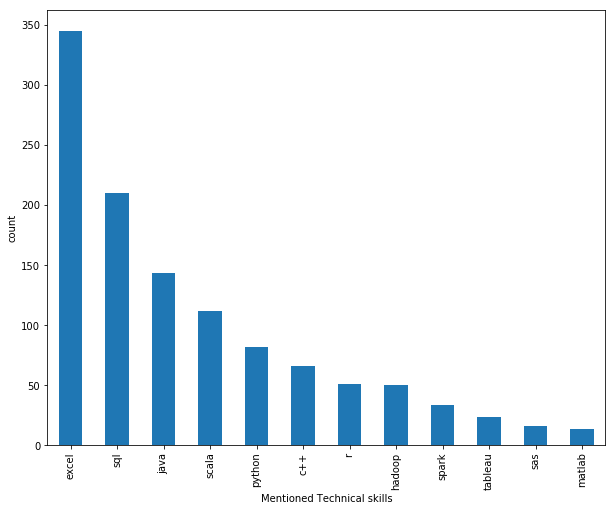

excel      345
sql        210
java       143
scala      112
python      82
c++         66
r           51
hadoop      50
spark       33
tableau     23
sas         16
matlab      13
dtype: int64

In [18]:
skillvis(final_skill_required_engineer2)

### Data Analyst Analysis

In [19]:
# define a new dataframe to store the evaluation results 
skills = ['job_title','company_name','location', 'job_link','python', 'r', "sql", 'sas', 'java', 'matlab', 'c++', 'scala','excel','hadoop','spark','tableau', 'total_skills_count'] #'job link',
skill_required2 = pd.DataFrame(columns = skills)

link_input = list()
python_input = list()
r_input = list()
sql_input = list()
sas_input = list()
java_input = list()
MATLAB_input = list()
Cplus_input = list()
scala_input = list()
excel_input = list()
hadoop_input = list()
spark_input = list()
tableau_input = list()
total_input = list()

linklist = list()
max_results_per_city = 11
job_title = []
company_name = []
location = []

In [20]:
Link_final_analyst, final_skill_required_analyst = getlinkindeed ('data+analyst', skill_required2)

In [21]:
final_skill_required_analyst2 = getjobsummary (final_skill_required_analyst)
final_skill_required_analyst2.head()

,job_title,company_name,location,summary,python,r,sql,sas,java,matlab,c++,scala,excel,hadoop,spark,tableau,total_skills_count,job_link
0,Sr. Financial Analyst,Kanetix Ltd,"Toronto, ON",join canada's fastest-growing internet technol...,0,0,0,0,0,0,0,0,2,0,0,0,2,https://www.indeed.com//company/Kanetix-Ltd/jo...
1,Consumer Insights and Reporting Analyst (12 mo...,Nestlé Canada Inc.,"North York, ON","good food, good lifeis the very essence of nes...",0,0,0,0,0,0,0,0,1,0,0,0,1,https://www.indeed.com//rc/clk?jk=8b470123c646...
2,Delphi Software Developer,Acceo Solutions,"Toronto, ON","smart vendor, a division of acceo solutions, i...",0,0,2,0,0,0,0,0,1,0,0,0,3,https://www.indeed.com//rc/clk?jk=83355370056c...
3,Technical Business Analyst,"Alquemy- Toronto,ON","Toronto, ON",job title : technical business analystlocation...,0,0,1,0,0,0,0,0,1,0,0,0,2,https://www.indeed.com//rc/clk?jk=498f8d4c6624...
4,Property Tax Analyst,Town of Milton,"Milton, ON",the town of milton’s corporate services depart...,0,0,0,0,0,0,0,0,1,0,0,0,1,https://www.indeed.com//rc/clk?jk=4e335a8324af...


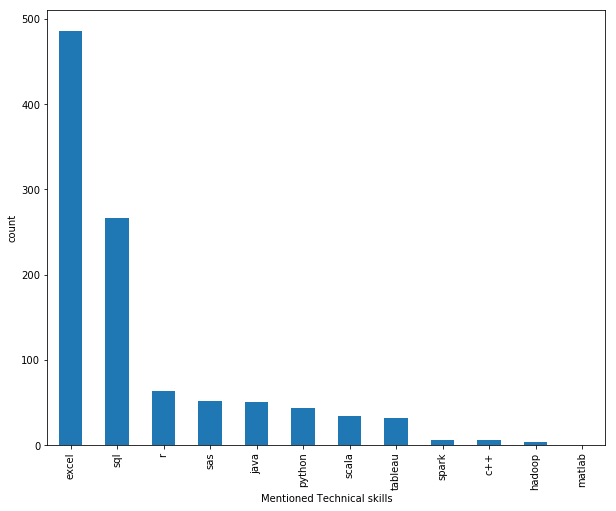

excel      486
sql        266
r           63
sas         52
java        50
python      44
scala       34
tableau     32
spark        6
c++          6
hadoop       3
matlab       0
dtype: int64

In [22]:
skillvis (final_skill_required_analyst2)

###### Total skills count - sum of skills required from "Data Scientist", "Data Analyst" and "Data Engineer"

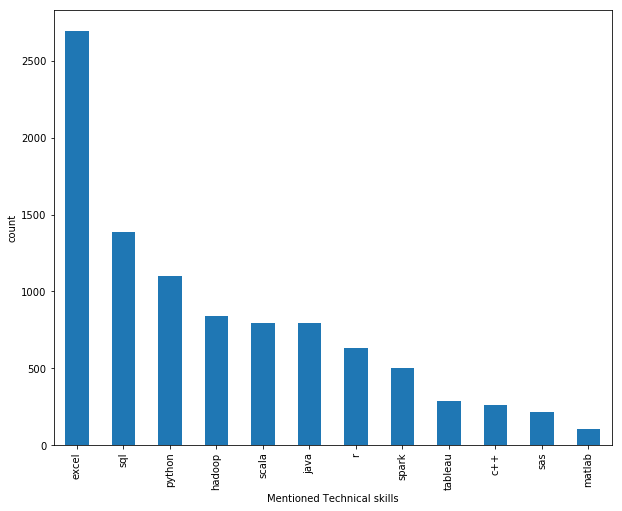

In [23]:
c1 = final_skill_required2[['python', 'r', "sql", 'sas', 'java', 'matlab', 'c++', 'scala','excel','hadoop','spark','tableau']].sum()
c2 = final_skill_required_engineer2[['python', 'r', "sql", 'sas', 'java', 'matlab', 'c++', 'scala','excel','hadoop','spark','tableau']].sum()
c3 = final_skill_required_analyst2[['python', 'r', "sql", 'sas', 'java', 'matlab', 'c++', 'scala','excel','hadoop','spark','tableau']].sum()
total_skills_count = c1 + c2 + c3
dataplot = total_skills_count
plt.figure(figsize=(10,8))
dataplot = dataplot.sort_values(ascending=False)
dataplot.plot(kind='bar')
plt.ylabel('count')
plt.xlabel('Mentioned Technical skills')
plt.show()

## Frequent Word Analysis

In [24]:
# count top frequent words based on Cleanedtext column as boolean format
# word features

def dataPreprocessor(k, directorydfcol):
    ''' This function cleaned dataframe into features with top frequemt words'''
    reviews = directorydfcol['summary'].as_matrix()
    Word_List=[]
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english')
    stopwords.append('data')
    stopwords.append('scientists')
    stopwords.append('scientist')
    stopwords.append('science')
    stopwords.append('analytics')
    stopwords.append('analysis')
    
    
    lemmatizer = nltk.WordNetLemmatizer() #meaingfull
    counter = Counter()
    for comment in reviews:
        for word in comment:
            lemmatizer.lemmatize(word)
            Word_List.append(word)
        counter.update([word.lower() for word in re.findall(r'\w+', comment) 
                        if word.lower() not in stopwords and len(word) > 2])

    topk = counter.most_common(k)  
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finaldf = directorydfcol.join(freqReviewDf)

    return topk, finaldf   

In [25]:
topkword, worddf =dataPreprocessor(25, final_skill_required2) 

In [26]:
topkword

[('experience', 6731),
 ('work', 4862),
 ('team', 4241),
 ('development', 3853),
 ('business', 3761),
 ('research', 3410),
 ('learning', 3063),
 ('technical', 2760),
 ('skills', 2712),
 ('new', 2506),
 ('knowledge', 2471),
 ('working', 2420),
 ('management', 2416),
 ('machine', 2411),
 ('including', 2378),
 ('project', 2208),
 ('support', 2188),
 ('years', 2154),
 ('amp', 2080),
 ('solutions', 2069),
 ('environment', 1985),
 ('software', 1969),
 ('ability', 1907),
 ('design', 1896),
 ('projects', 1816)]

## Frequent Phrases Analysis

In [27]:
# prepare data to feed into the model, independent variables as sentiment score of each tweet
# n-gram by its part of speech 
tagger = PerceptronTagger()
pos_tag = tagger.tag
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

chunker = nltk.RegexpParser(grammar)
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.append('data')
stopwords.append('scientists')
stopwords.append('scientist')
#lemmatizer = nltk.WordNetLemmatizer()
#stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
#    word = stemmer.stem(word)
#    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term
            
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [28]:
# Revise the previous dataframe transform function...
def TopfreqPhrase(reviewDF, k):
    reviews = reviewDF['summary'].as_matrix()
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finaldf = reviewDF.join(freqReviewDf)
    return topk, finaldf

In [29]:
topkphrase, phrasedf = TopfreqPhrase(final_skill_required2,25) 

In [30]:
topkphrase

[('successful candidate', 454),
 ('machine learning', 426),
 ('equal opportunity employer', 347),
 ('years experience', 300),
 ('communication skills', 234),
 ('north america', 197),
 ('machine learning models', 178),
 ('innovative solutions', 169),
 ('cross functional teams', 153),
 ('ideal candidate', 152),
 ('wide range', 150),
 ('bachelor degree', 143),
 ('wide variety', 142),
 ('catalyst specialist', 140),
 ('software developers', 139),
 ('reasonable accommodations', 137),
 ('clinical research', 135),
 ('present findings', 133),
 ('big technologies', 130),
 ('team members', 129),
 ('global leader', 127),
 ('cover letter', 126),
 ('qualified applicants', 126),
 ('full time', 124),
 ('new technologies', 123)]

## Mutual Information Analysis

In [31]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='total_skills_count'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [32]:
miScoredf = getMI(topkword, worddf)
miScoredf.head(10)

,Word,MI Score
13,machine,0.198307
6,learning,0.195556
15,project,0.107512
11,working,0.101424
19,solutions,0.097244
8,skills,0.092692
23,design,0.071230
4,business,0.069617
1,work,0.069061
21,software,0.068721


## Topic Analysis

In [44]:
no_features = 500
no_topics = 20
no_top_words = 15

def topicsanalysis(data): 
    # NMF is able to use tf-idf
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(data)
    tf_feature_names = tf_vectorizer.get_feature_names()
    
    # Run NMF
    nmf = NMF(n_components = no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

    # Run LDA
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    
    return tfidf_feature_names, tf_feature_names, nmf

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [45]:
tfidf_feature_names1, tf_feature_names1,nmf = topicsanalysis(final_skill_required2['summary'])
display_topics(nmf, tfidf_feature_names1, no_top_words)

Topic 0:
software customer technical team product applications solutions understand developers customers support company new issues based
Topic 1:
environmental field work site project professional office position safety water consulting construction assessment clients engineering
Topic 2:
catalyst petrochemical area manage technical projects lead development ideas good research identify chemical specialist experimental
Topic 3:
clinical study regulatory scientific research medical protocols development studies documents scientist excellent reports provide health
Topic 4:
rbc bank analytics personal clients opportunity learning protected largest communities disability digital public new statistical
Topic 5:
ai lg learning machine vision toronto leadership research global deep systems address build lab product
Topic 6:
capital year experience banking customers code modeling financial source learn open canada information position tools
Topic 7:
learning machine deep science computer ai e

## Data Visualization (Others)

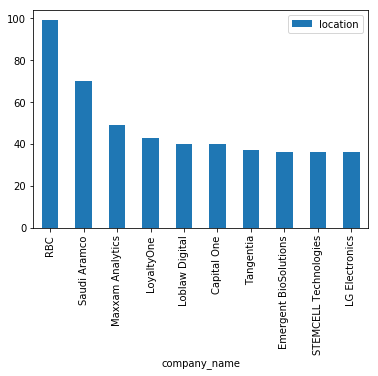

In [35]:
# check which companies are hiring the most "Data Scientist" jobs

countcompany = final_skill_required2[["company_name", "location"]].groupby('company_name').count()
countcompany1 = countcompany.sort_values(by=['location'], ascending=False)
countcompany_final = countcompany1.iloc[:10,:]
countcompany_final
countcompany_final.plot(kind='bar')
plt.show()

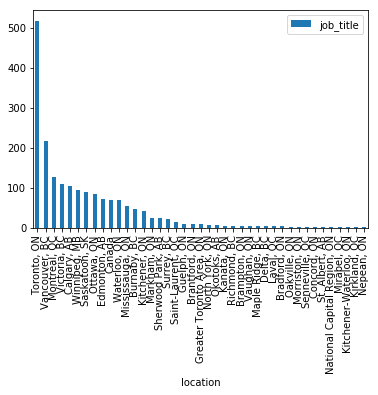

In [36]:
# Might needn to organize them into provinces 
# check which cities are hiring the most "Data Scientist" jobs

countlocation = final_skill_required2[["job_title", "location"]].groupby('location').count()
countlocation = countlocation.sort_values(by=['job_title'], ascending=False)
countlocation.plot(kind='bar')
plt.show()

## Appendix A: Scraping Indeed Homepage - with only part of job summary

In [37]:
city_set = ['Toronto','Vancouver','Montreal','Mississauga','Calgary','Edmonton','Ottawa','Winnipeg','Burnaby','Concord','Waterloo','Victoria','Markham','Saskatoon']
columns = ['city', 'job_title', 'company_name', 'location', 'summary', 'salary']
sample_df = pd.DataFrame(columns = columns) 

In [38]:
max_results_per_city = 25

salarylist = list()
citylist = list()
jobtitle = list()
companylist = list()
locationlist = list()
jobsum = list()

start = time.time()
for city in city_set:
    for start in range(0, max_results_per_city, 10):
        page = requests.get('https://ca.indeed.com/jobs?q=data+scientist&l=' + str(city) + '&sort=date'+'&start=' + str(start))
        #print('https://ca.indeed.com/jobs?q=data+scientist&l=' + str(city)+'&sort=date' + '&start=' + str(start))
        
        time.sleep(0.01)
        soup = BeautifulSoup(page.text, 'lxml')#, from_encoding='utf-8')
        for div in soup.find_all(name="div", attrs={"class":"row"}):
            
            job_posting = []
            
            #append city name
            job_posting.append(city)
            citylist.append(city)
            
            #append job title
            for a in div.find_all(name="a", attrs={'data-tn-element':'jobTitle'}):
                job_posting.append(a['title'])
                jobtitle.append(a['title'])
                                
            #append company name
            company = div.find_all(name="span", attrs={"class":"company"})
            if len(company) > 0:
                for b in company:
                    job_posting.append(b.text.strip())
                    companylist.append(b.text.strip())
                else:
                    sec_try = div.find_all(name="span", attrs={"class":"result-link-source"})
                    for span in sec_try:
                        job_posting.append(span.text)
                        companylist.append(span.text)
                        
            #append location
            c = div.findAll('span', attrs={'class': 'location'})
            for span in c:
                job_posting.append(span.text)
                locationlist.append(span.text)

            #append job summary
            d = div.findAll('span', attrs={'class': 'summary'})
            for span in d:
                job_posting.append(span.text.strip())
                jobsum.append(span.text.strip())
                
            #append salary
            try:
                div_two = div.find(name = 'div', attrs = {'class' : 'sjcl'})
                div_three = div_two.find('div')
                job_posting.append(div_three.text.strip())
                salarylist.append(div_three.text.strip())

            except:
                job_posting.append('N/A')  
                salarylist.append('N/A')
            
        #sample_df.loc[num] = job_posting
        #sample_df = sample_df.append(job_posting, ignore_index=True) 
    
        #print(job_posting)

end = time.time()
print ('Execution time =', end - start)

print(len(citylist))
print(len(jobtitle))
print(len(companylist))
print(len(locationlist))
print(len(jobsum))
print(len(salarylist))
lengthdata = min(len(citylist),len(jobtitle),len(companylist),len(locationlist),len(jobsum),len(salarylist))-1

sample_df['city'] = citylist[:lengthdata]
sample_df['job_title'] = jobtitle[:lengthdata]
sample_df['company_name'] = companylist[:lengthdata]
sample_df['location'] = locationlist[:lengthdata]
sample_df['summary'] = jobsum[:lengthdata]
sample_df['salary'] = salarylist[:lengthdata]

Execution time = 1521326638.1040401
541
541
584
541
541
541


In [39]:
sample_df

,city,job_title,company_name,location,summary,salary
0,Toronto,Senior Environmental Scientist,Arcadis,"Mississauga, ON","Analyze data, write reports, provide quality c...",N/A
1,Toronto,Financial Reporting Analyst,Xaxis,"Toronto, ON","Xaxis combines proprietary technology, unique ...",N/A
2,Toronto,Finance Partner,SickKids,"Toronto, ON",Ability to monitor expenditures and maintain d...,N/A
3,Toronto,Full Stack Developer - Pipeline,EQ Works,"Toronto, ON",Mobile data allowance. You will be working clo...,N/A
4,Toronto,Software Development Manager,Autodesk,"Toronto, ON",Experience with data visualization and web fra...,N/A
5,Toronto,Senior Data Scientist,CIBC,"Toronto, ON",Data Science Expertise:. As a Senior Data Scie...,N/A
6,Toronto,"Senior Manager, Business Insights and Analytics",TD Bank,"Toronto, ON",Experience managing a team of highly capable b...,N/A
7,Toronto,Administrative Assistant,DS Consultants Ltd,"Vaughan, ON",Light health and safety duties which can inclu...,N/A
8,Toronto,Process Scientist,Brevitas Consulting Inc.,"Greater Toronto Area, ON",Data analysis and preparation of raw data pack...,N/A
9,Toronto,Scientific Liaison,BenchSci,"Toronto, ON",We use machine learning to accelerate drug dis...,N/A


In [40]:
sample_df['summary']

0      Analyze data, write reports, provide quality c...
1      Xaxis combines proprietary technology, unique ...
2      Ability to monitor expenditures and maintain d...
3      Mobile data allowance. You will be working clo...
4      Experience with data visualization and web fra...
5      Data Science Expertise:. As a Senior Data Scie...
6      Experience managing a team of highly capable b...
7      Light health and safety duties which can inclu...
8      Data analysis and preparation of raw data pack...
9      We use machine learning to accelerate drug dis...
10     Being part of a large community of data scient...
11     Reporting to the Manager, Data Science we are ...
12     The Senior Director of Data Science will be le...
13     The Senior Director of Data Science will be le...
14     Being part of a large community of data scient...
15     Reporting to the Manager, Data Science we are ...
16     Alliance Data participates in E-Verify. Take a...
17     It will also be used by 